<a href="https://colab.research.google.com/github/ajsal-ali/zeroshot-object-detection-and-classification-/blob/main/Zeroshot_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers



  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-utg3_yv4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-utg3_yv4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import clip
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import numpy as np

In [ ]:
# Load models
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
owlvit_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
owlvit_model.to(device)

clip_model, preprocess = clip.load("ViT-B/32", device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

100%|███████████████████████████████████████| 338M/338M [00:14<00:00, 25.1MiB/s]


In [ ]:

def process_video_with_owlvit(video_path, text_labels):
    cap = cv2.VideoCapture(video_path)
    fps_list = []

    ret, frame = cap.read()

    height, width = frame.shape[:2]
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_with_owlvit.avi', fourcc, 2.0, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        start = time.time()
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Pass the frame and text labels into OwlViT model
        inputs = processor(text=text_labels, images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = owlvit_model(**inputs)

        # Post-processing step
        target_sizes = torch.tensor([(image.height, image.width)]).to(device)
        results = processor.post_process_grounded_object_detection(
            outputs, target_sizes=target_sizes, threshold=0.1, text_labels=text_labels
        )[0]

        boxes, scores, proc_text_labels = results["boxes"], results["scores"], results["text_labels"]

        # Annotate the frame with bounding boxes and labels using OpenCV (for video output)
        for box, score, label in zip(boxes, scores, proc_text_labels):
            xmin, ymin, xmax, ymax = map(int, box.tolist())
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
            cv2.putText(frame, f"{label}: {score:.2f}", (xmin, ymin - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        out.write(frame)

        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(frame)
        ax.axis('off')
        plt.tight_layout()
        plt.show()

        plt.close(fig)

        fps_list.append(1 / (time.time() - start))

    cap.release()
    out.release()
    print(f"Video saved as 'output_with_owlvit.avi'")
    print(f"Average FPS: {sum(fps_list)/len(fps_list):.2f}")

In [ ]:
def process_video_with_clip(video_path, text_labels):
    # Open the video
    cap = cv2.VideoCapture(video_path)
    fps_list = []

    ret, frame = cap.read()

    height, width = frame.shape[:2]
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to first frame

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_with_clip.avi', fourcc, 2.0, (width, height))

    # Preprocess text labels
    text_inputs = torch.cat([clip.tokenize([txt]) for txt in text_labels]).to(device)

    # Process the video frame by frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        start = time.time()

        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Preprocess image for CLIP
        image_input = preprocess(image).unsqueeze(0).to(device)

        # Get image and text features
        with torch.no_grad():
            image_features = clip_model.encode_image(image_input)
            text_features = clip_model.encode_text(text_inputs)

        # Normalize features and calculate cosine similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarity = (image_features @ text_features.T).squeeze(0)  # Cosine similarity

        # Get the top matching text label
        top_match_idx = similarity.argmax().item()
        top_match_score = similarity[top_match_idx].item()

        # Annotate the frame with the top matching label and score
        cv2.putText(frame, f"Top match: {text_labels[top_match_idx]} ({top_match_score:.2f})",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Display the frame in the notebook (using matplotlib)
        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(frame)  # Show the frame with text annotations
        ax.axis('off')
        plt.tight_layout()
        plt.show()  # Display the plot inline

        # Write the frame (with annotation) to the video output using OpenCV
        out.write(frame)  # Write the frame directly to the output video

        plt.close(fig)  # Close the plot to free memory

        end = time.time()
        fps_list.append(1 / (end - start))

    cap.release()
    out.release()
    print(f"Video saved as 'output_with_clip.avi'")
    print(f"Average FPS: {sum(fps_list)/len(fps_list):.2f}")

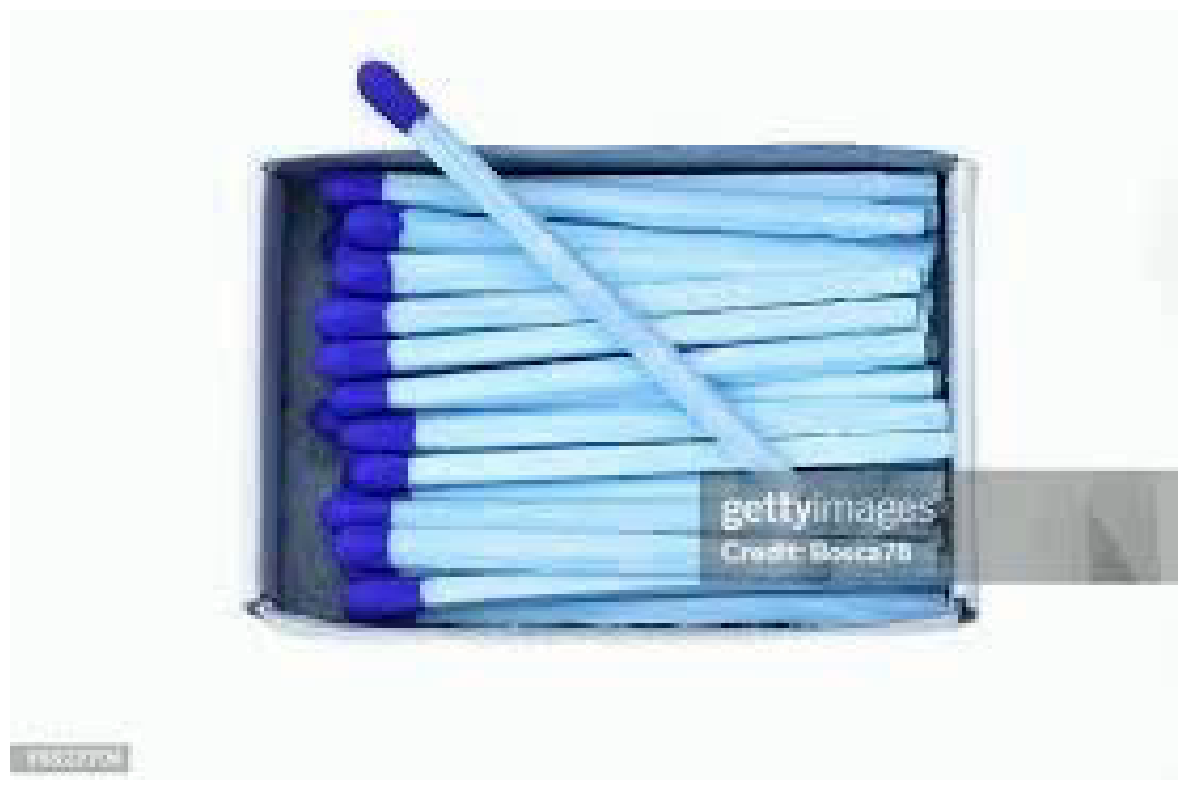

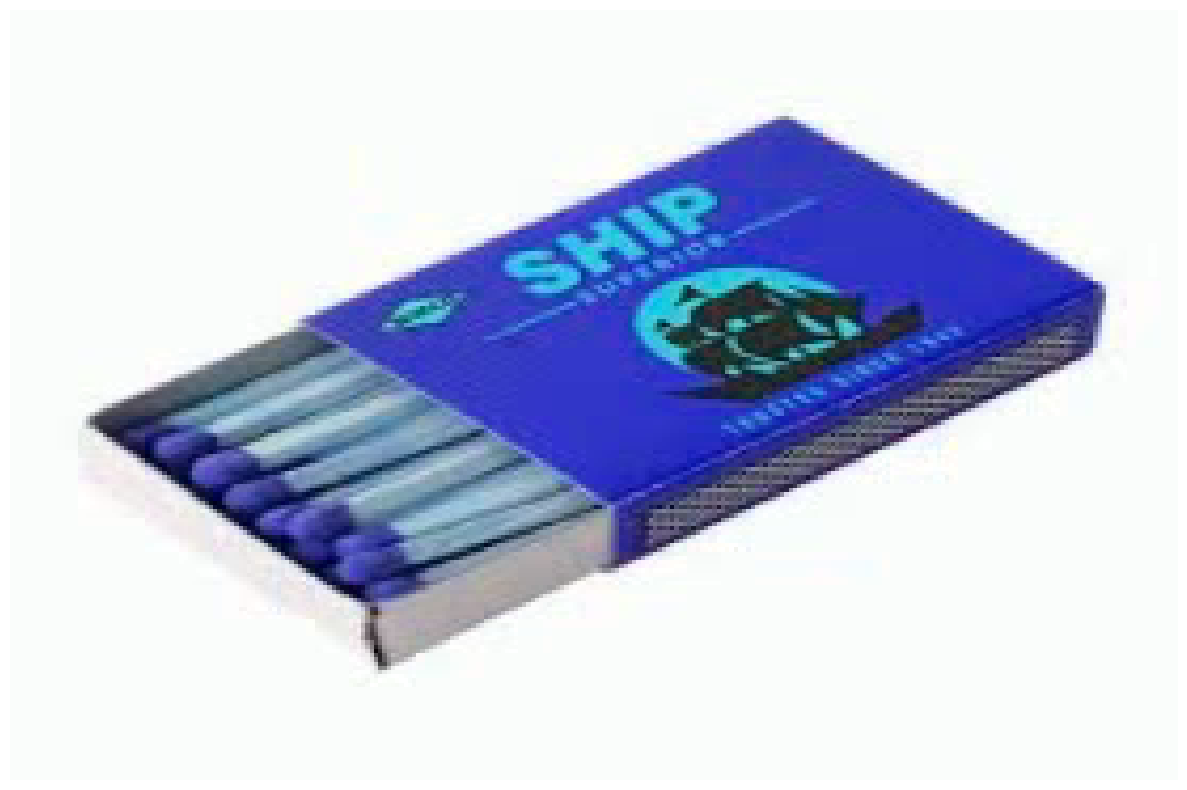

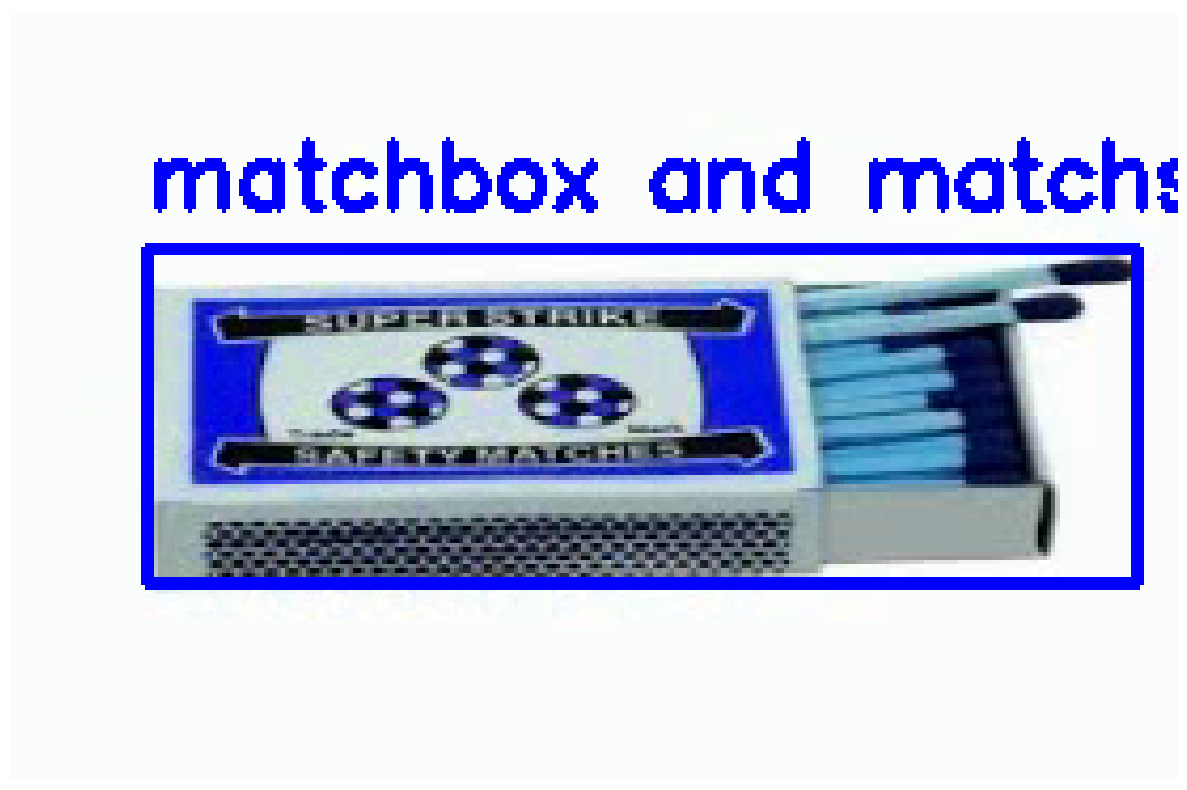

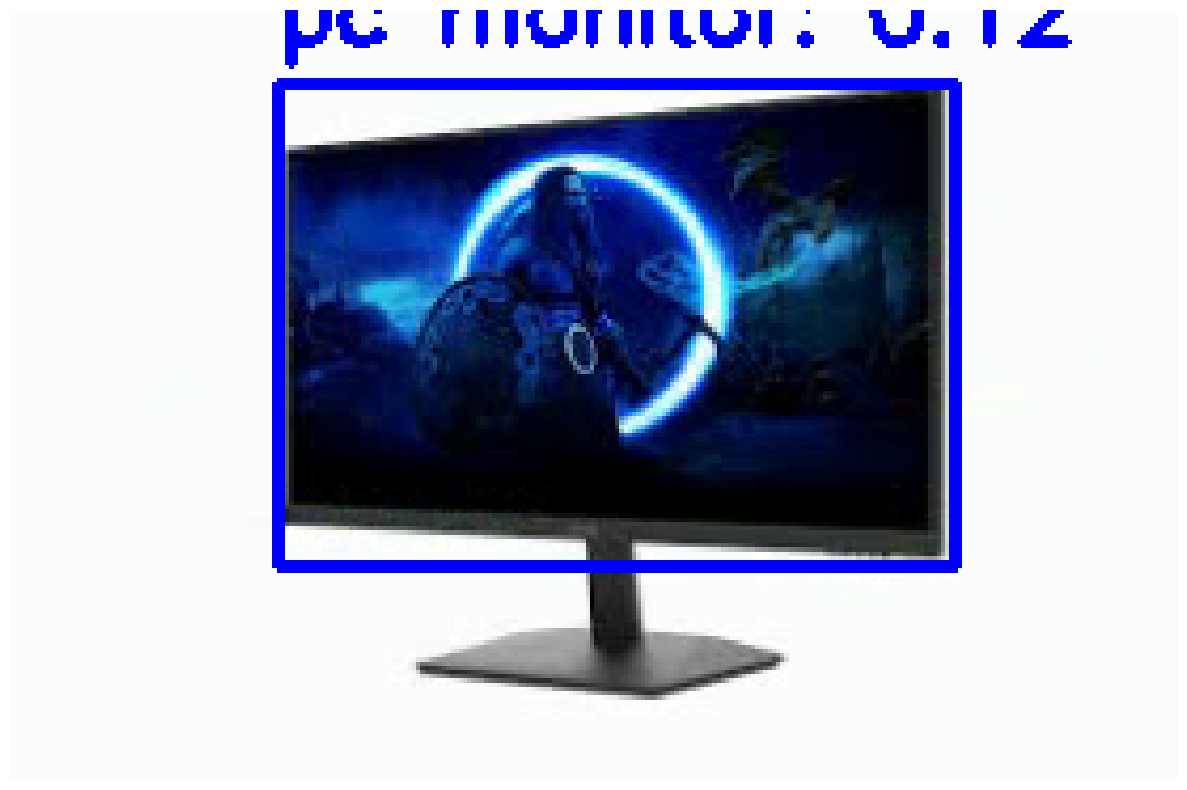

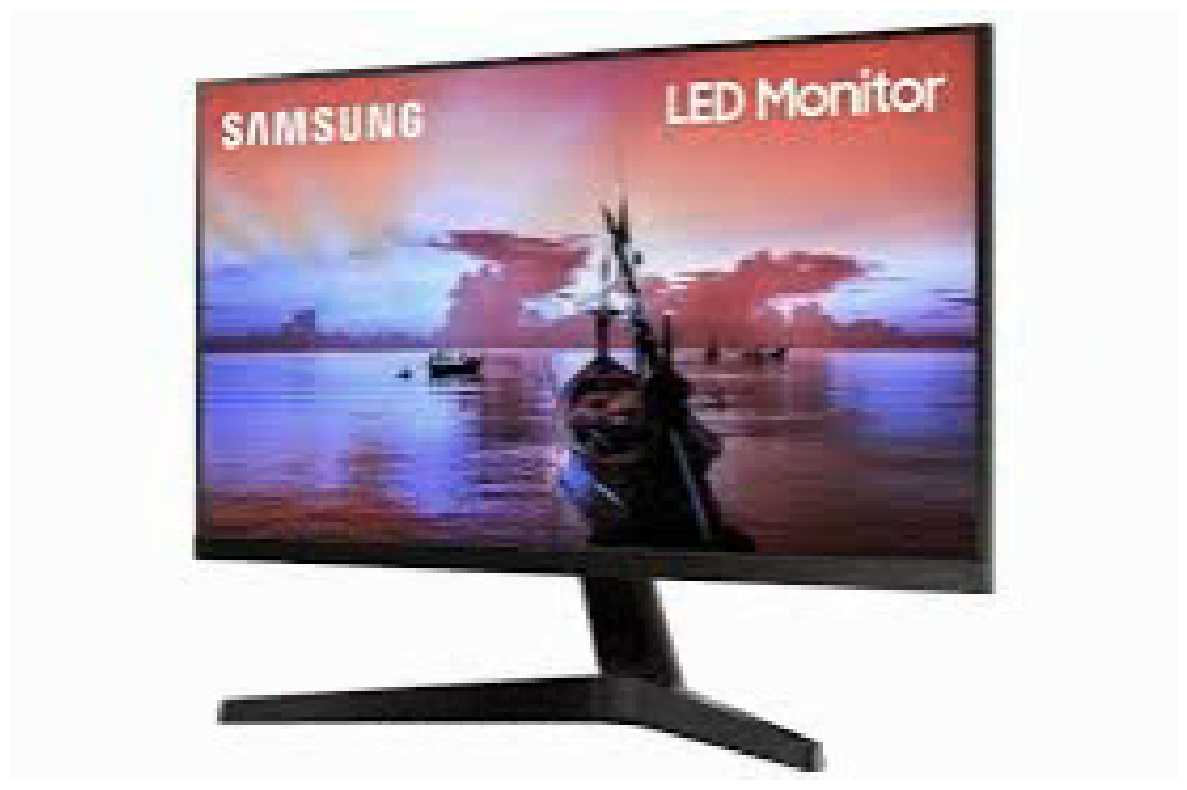

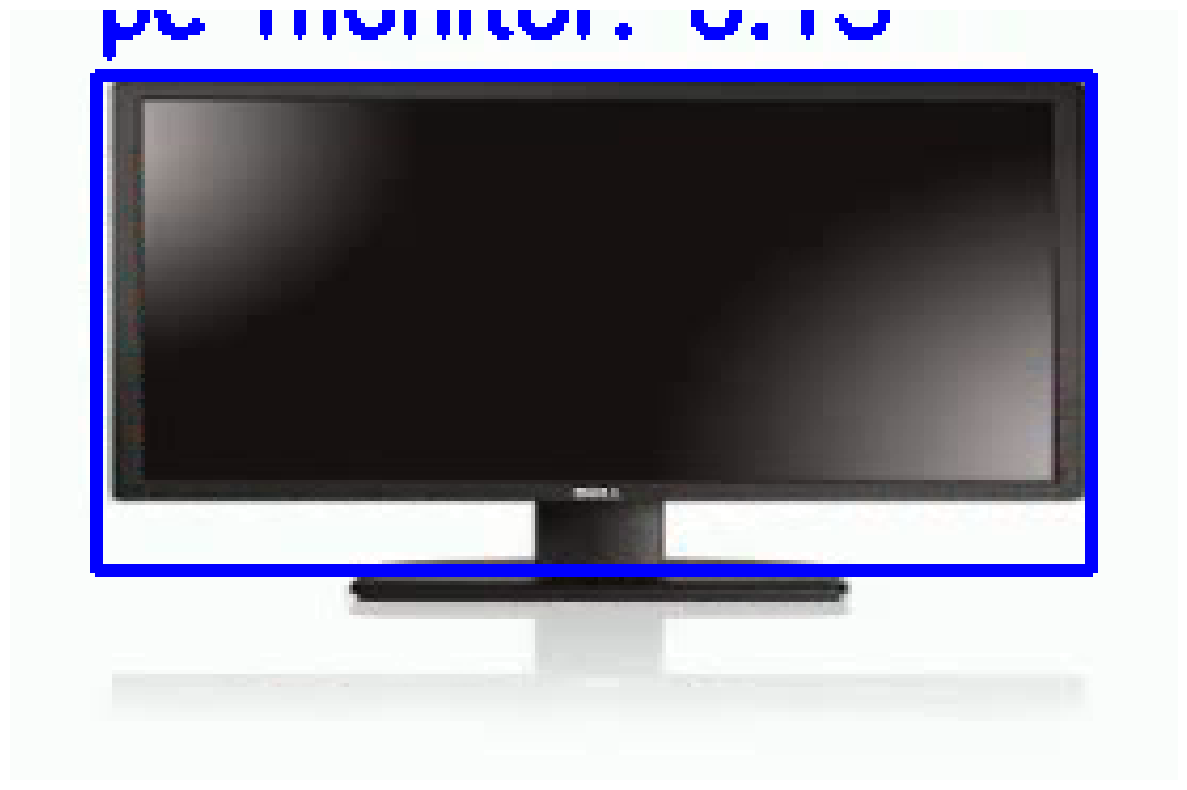

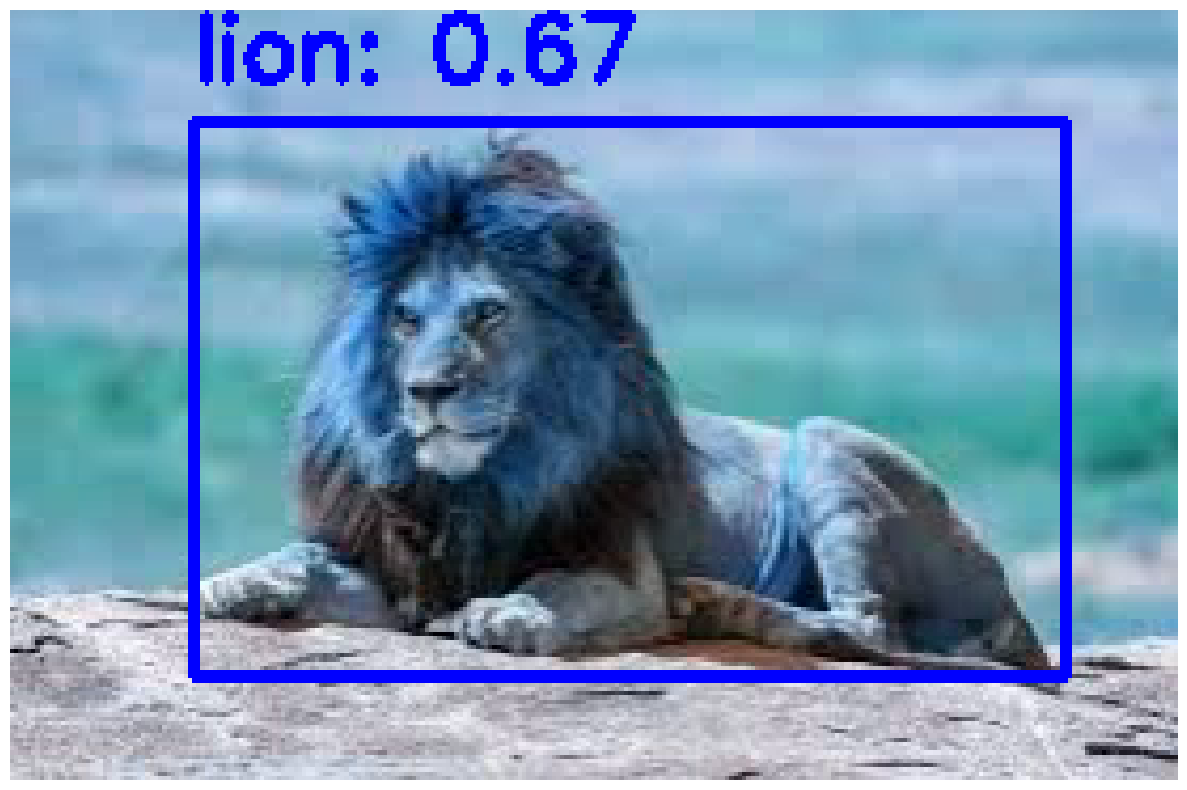

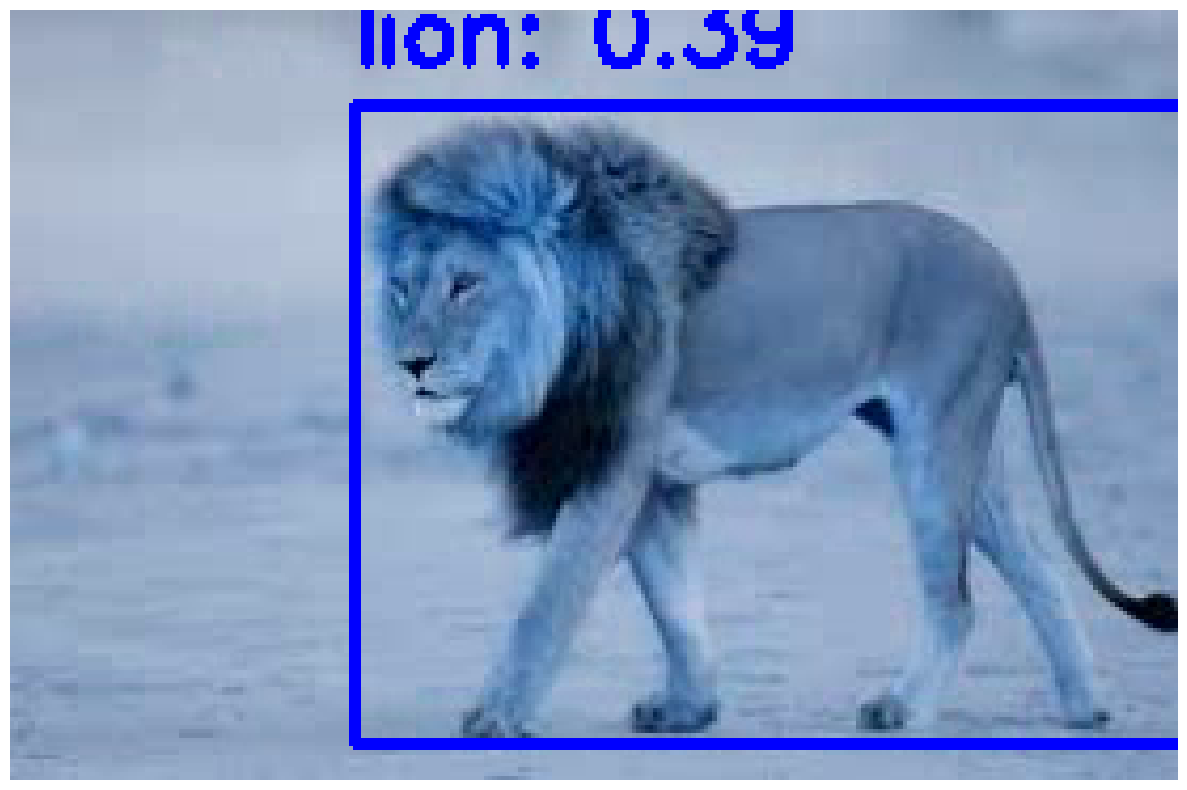

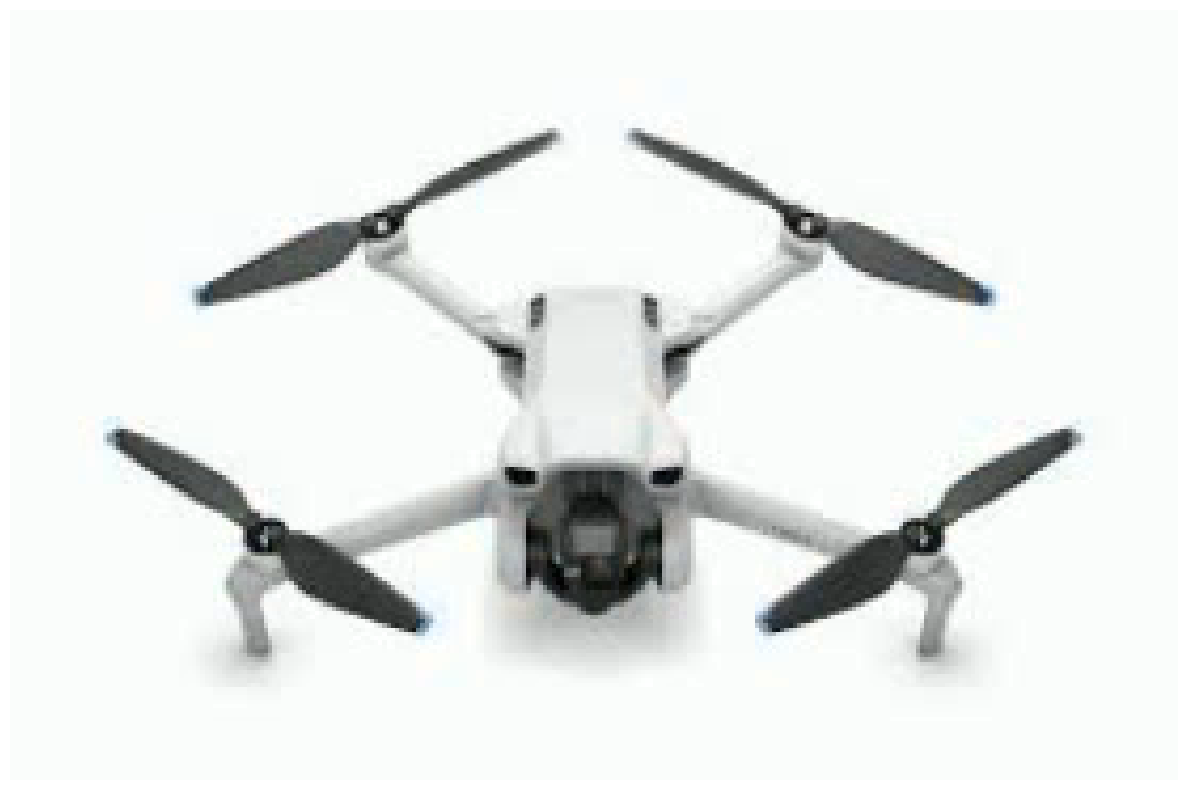

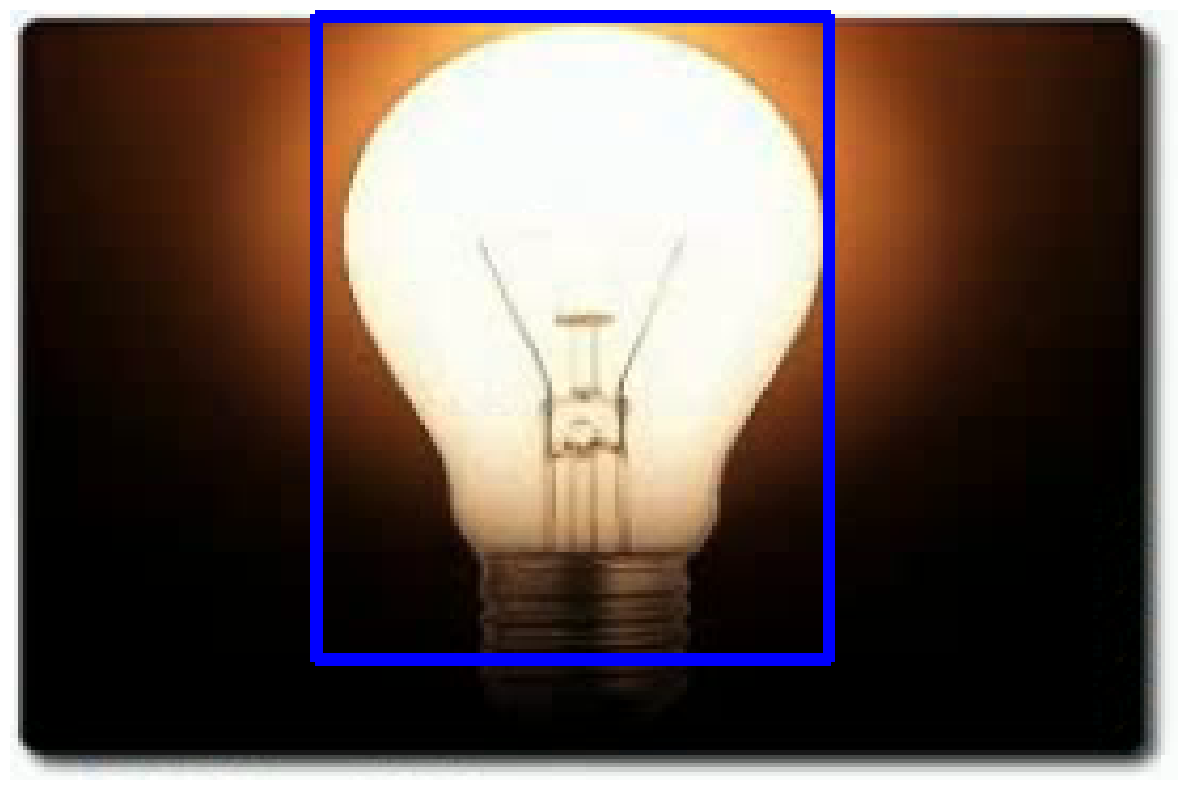

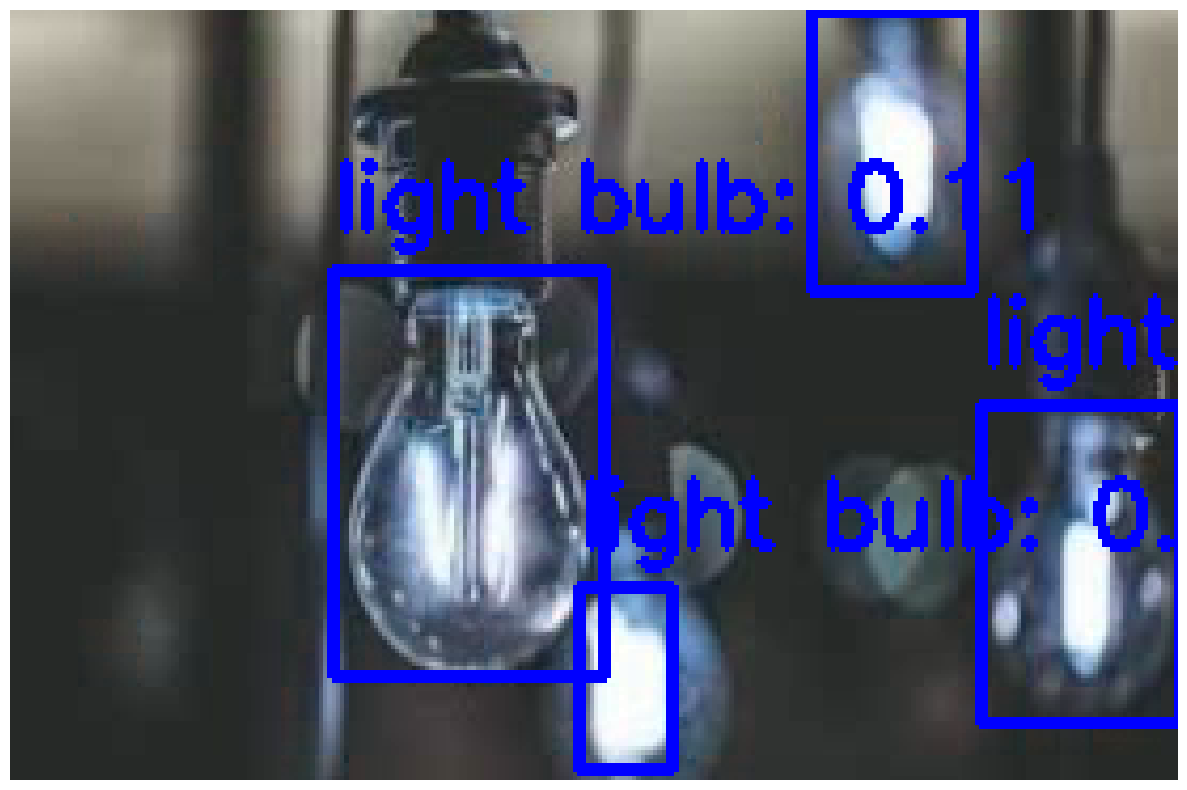

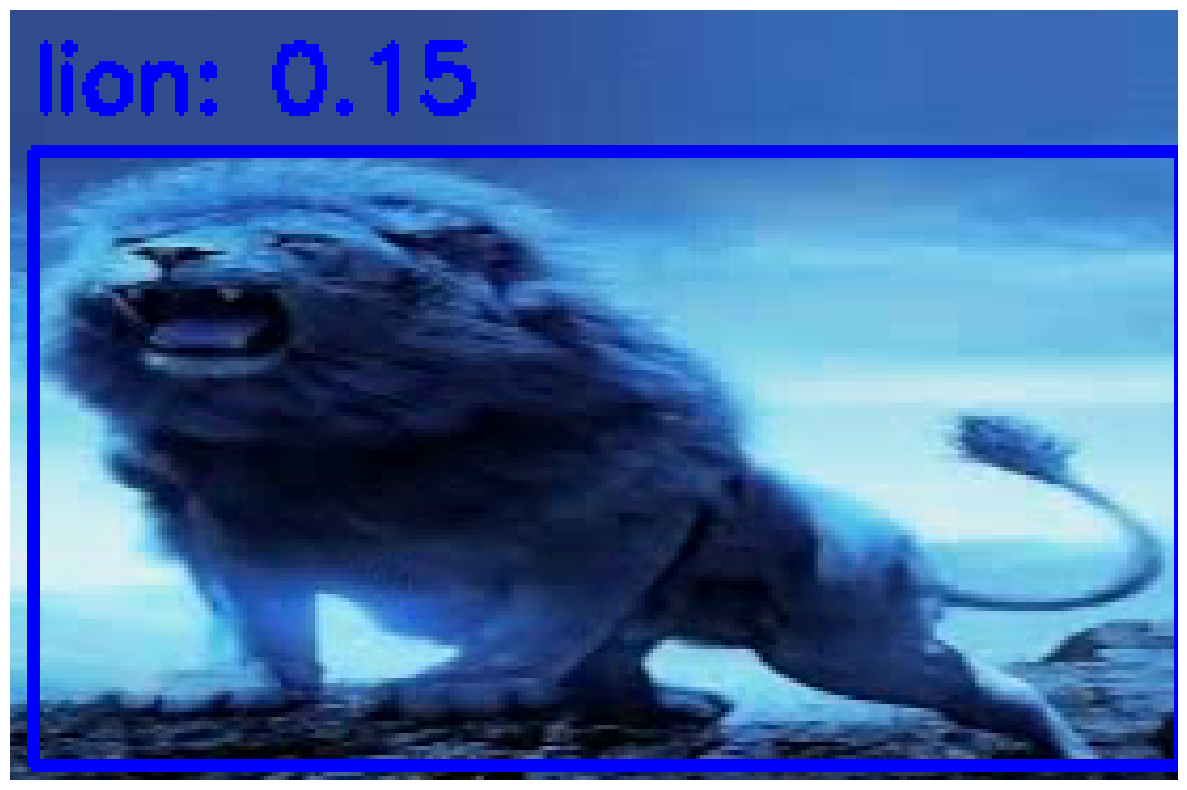

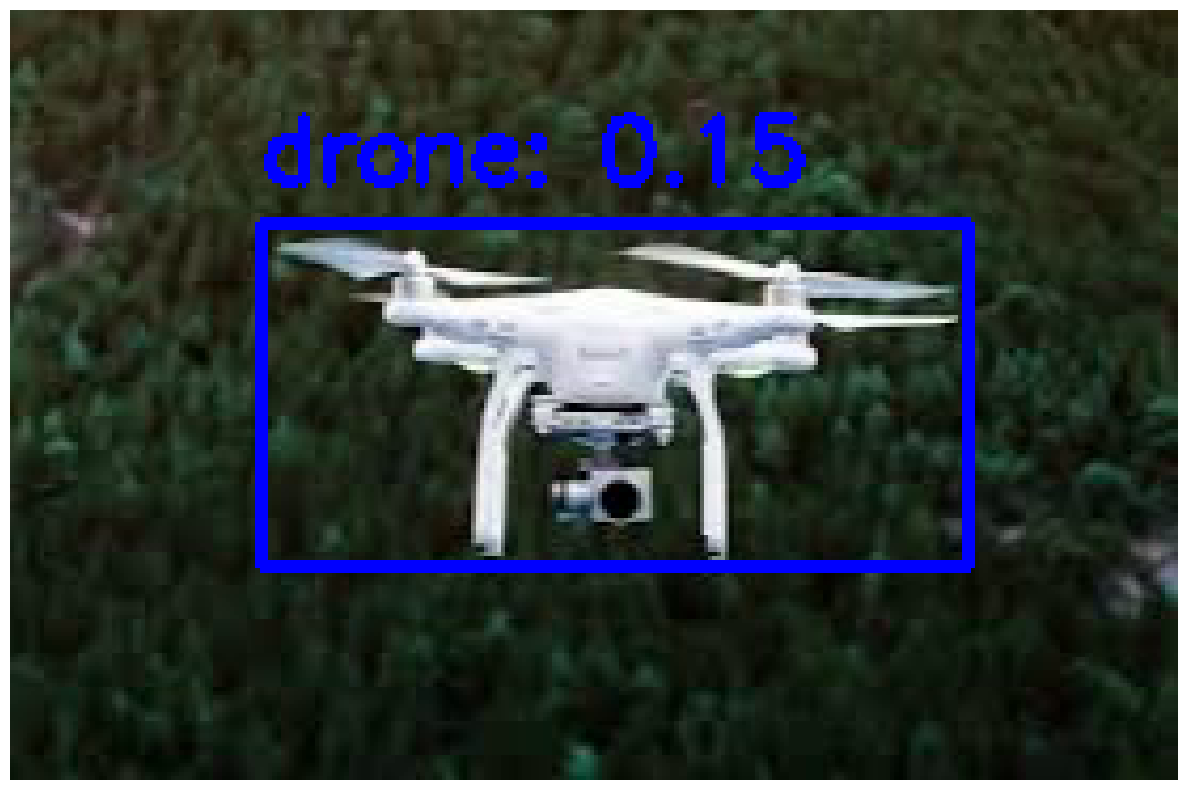

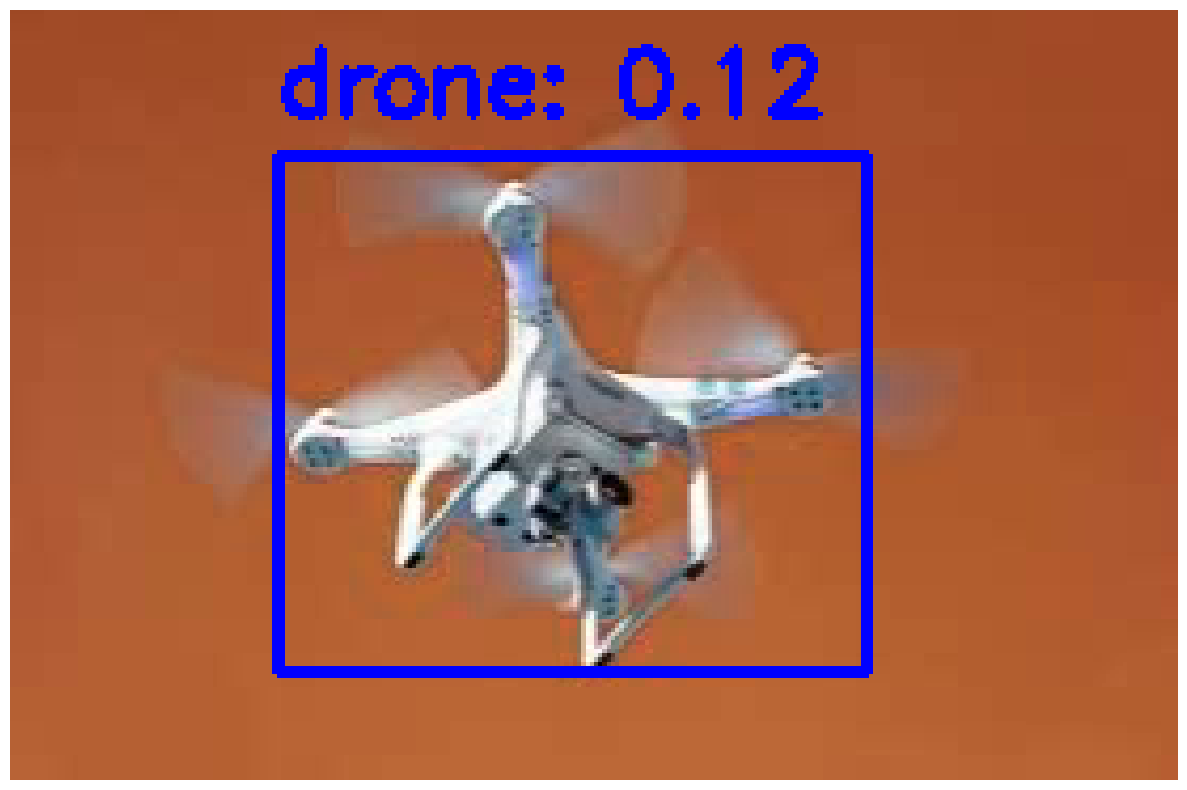

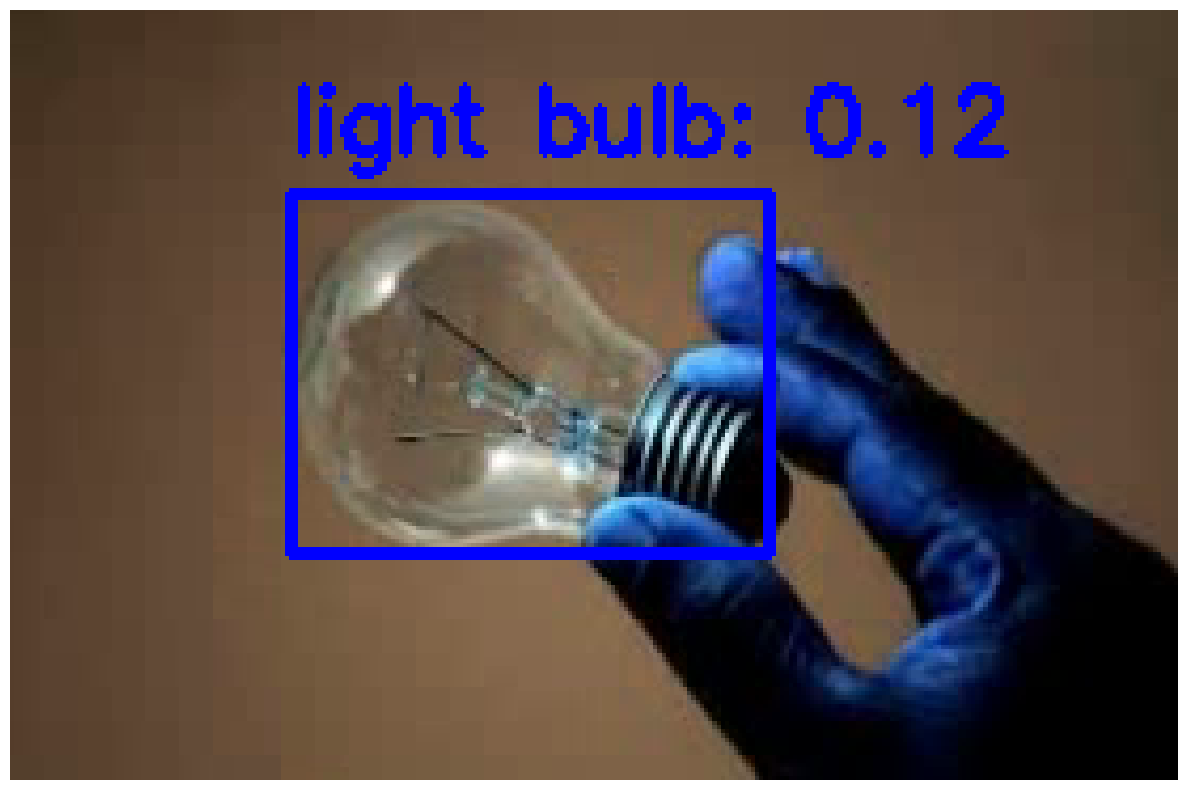

Video saved as 'output_with_owlvit.avi'
Average FPS: 5.11


In [ ]:
video_path = '/content/input_vid.avi'
text_labels = [["matchbox and matchsticks", "pc monitor", "lion", "drone", "light bulb"]]
process_video_with_owlvit(video_path, text_labels)


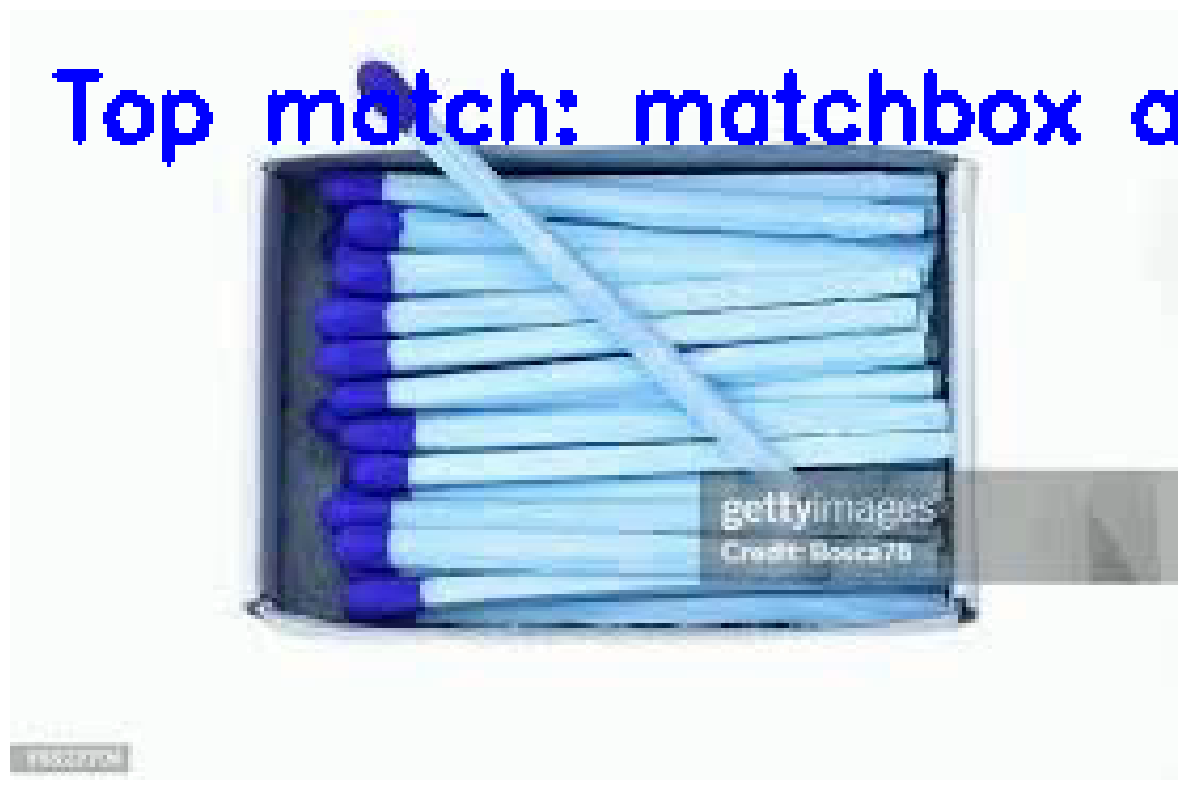

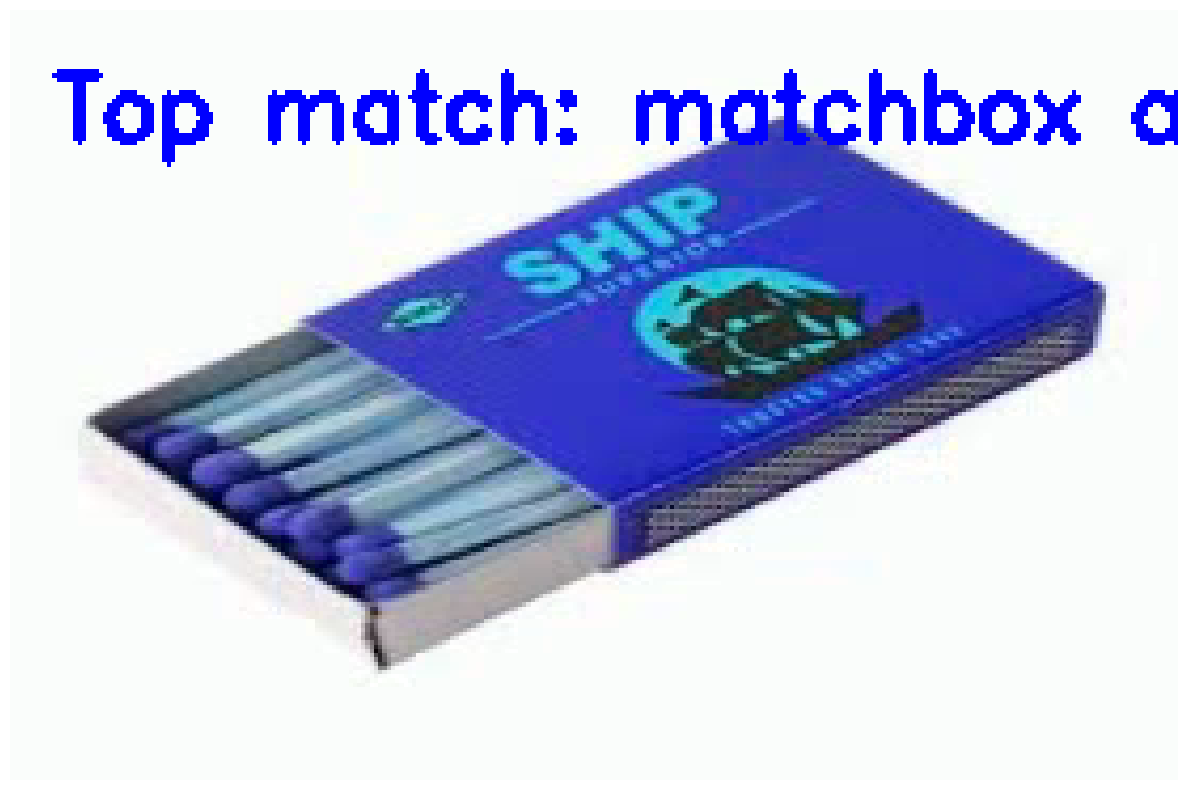

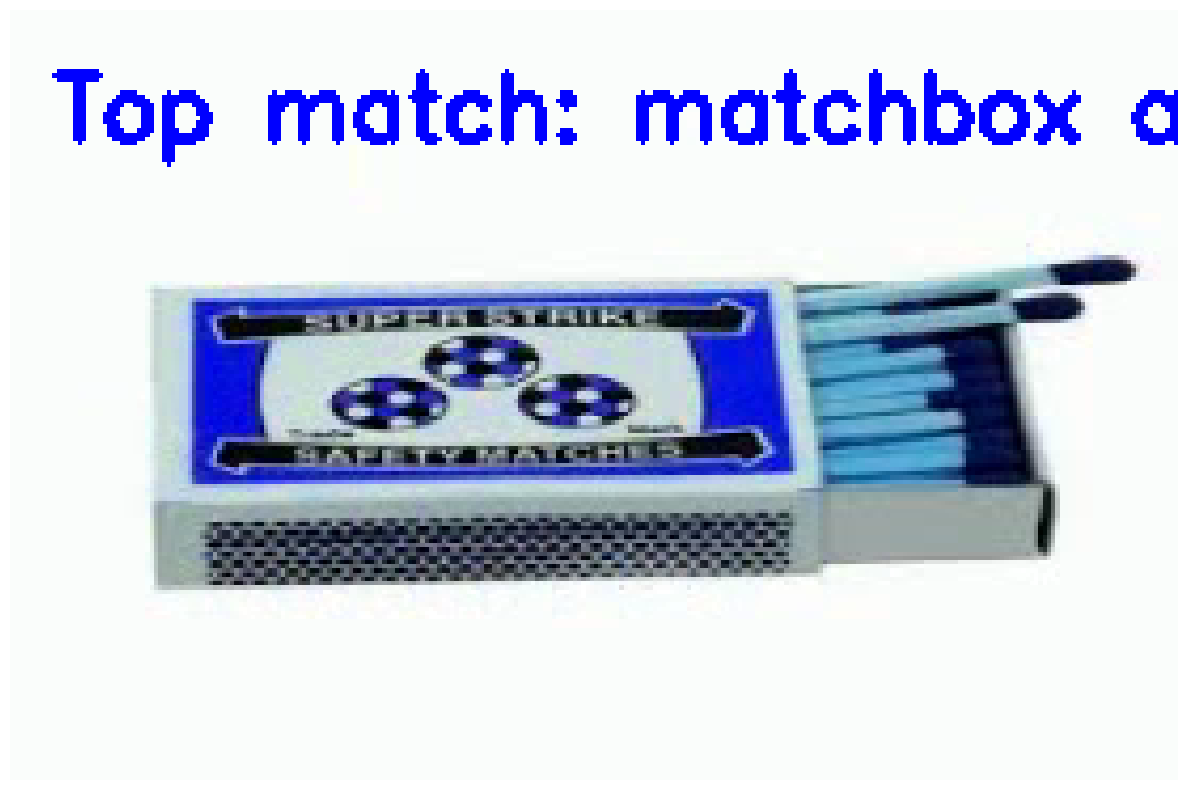

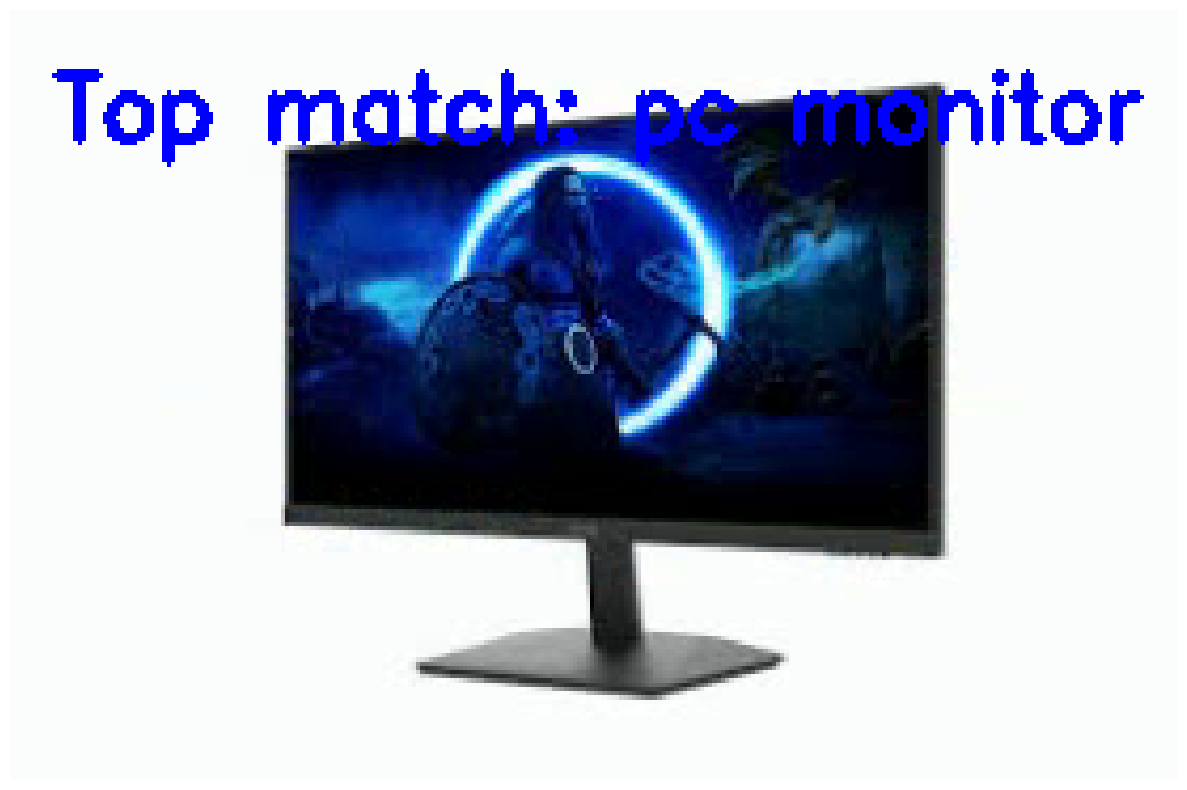

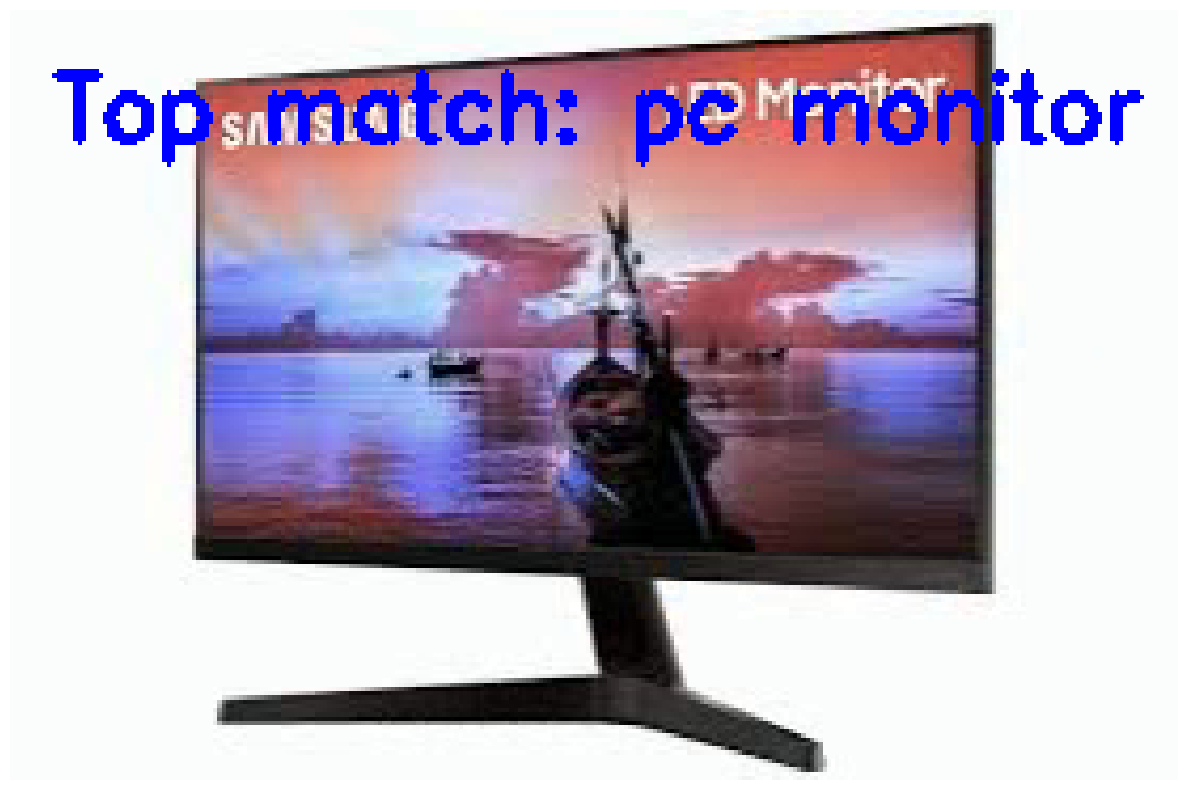

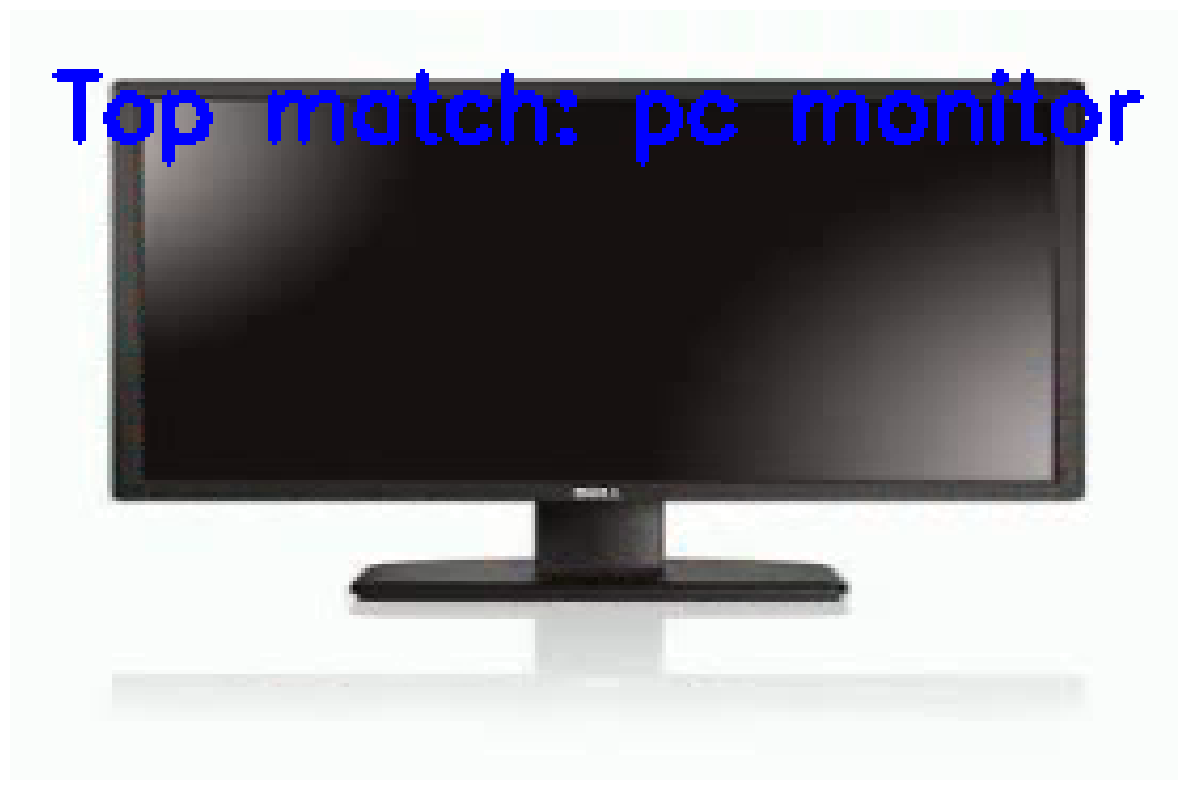

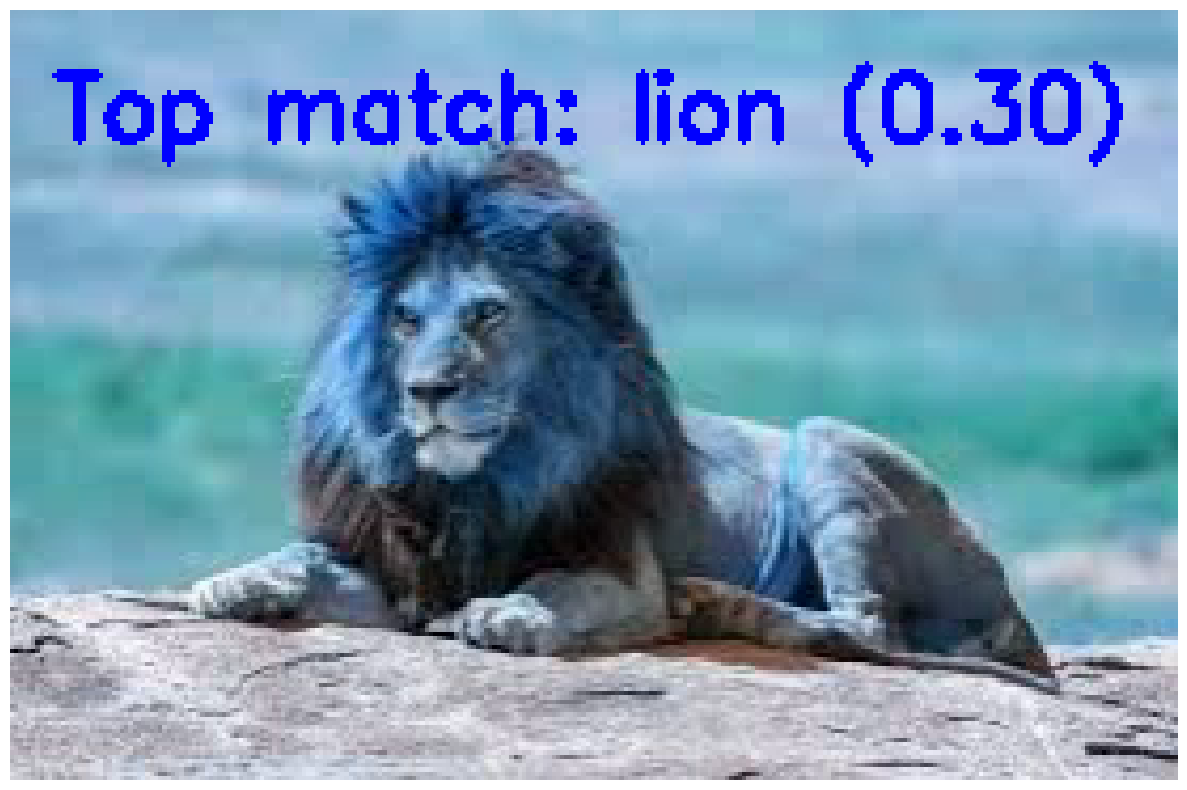

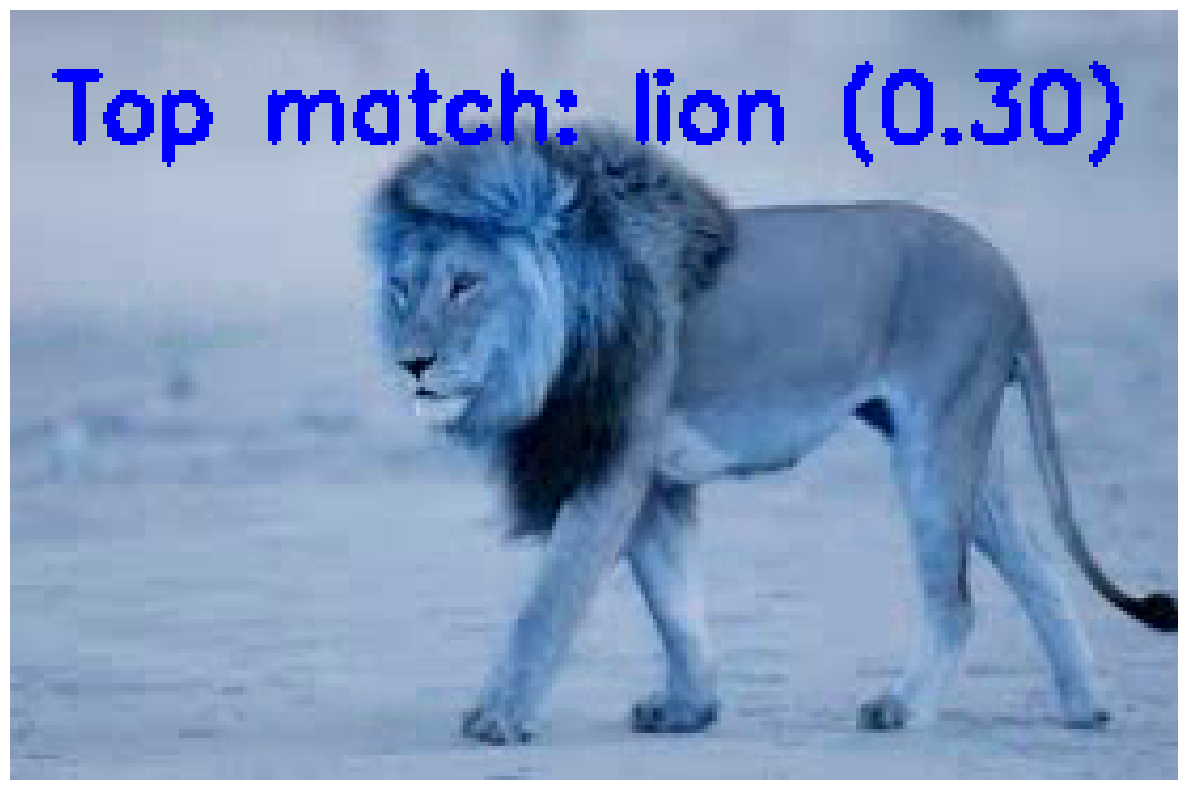

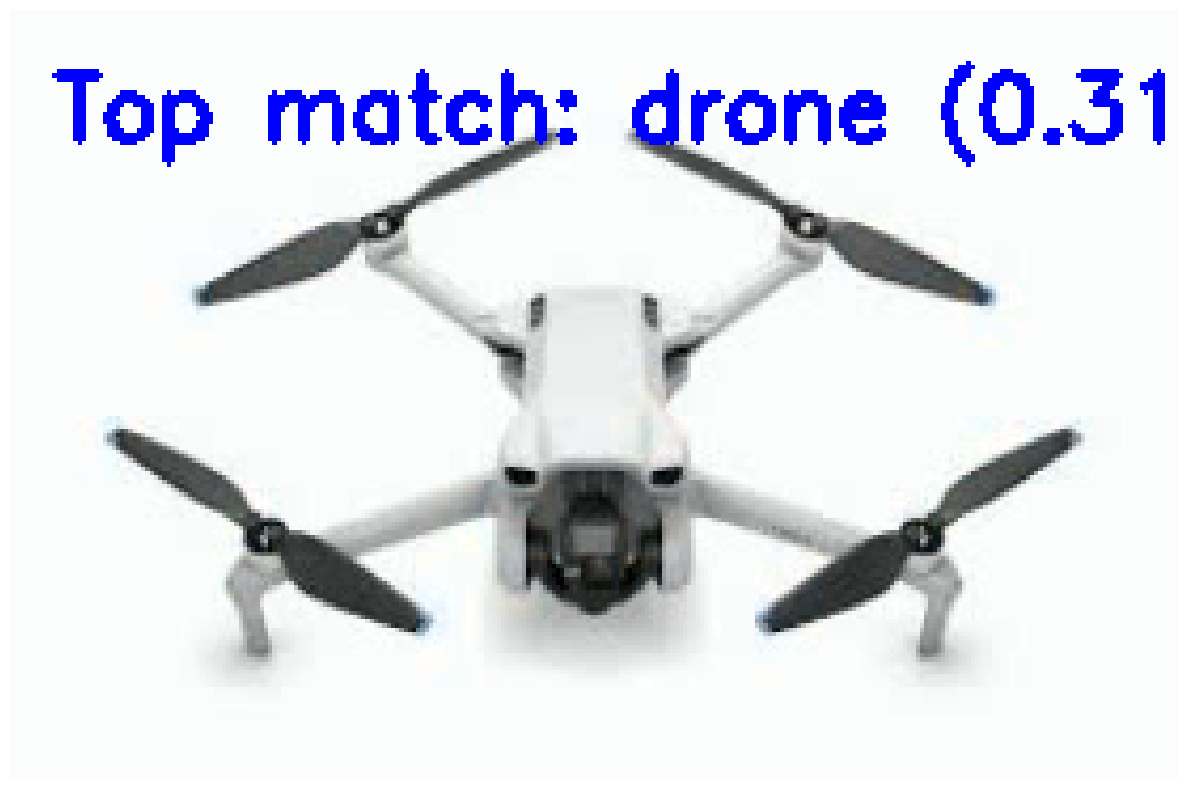

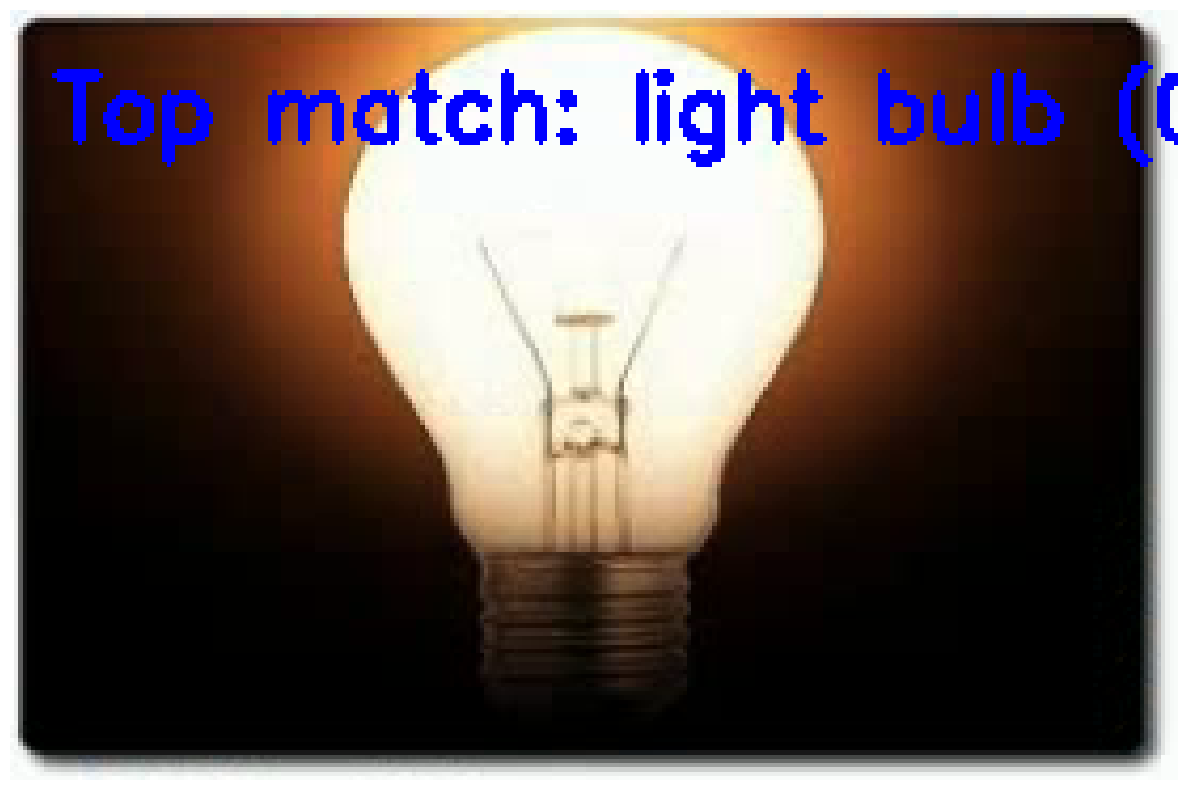

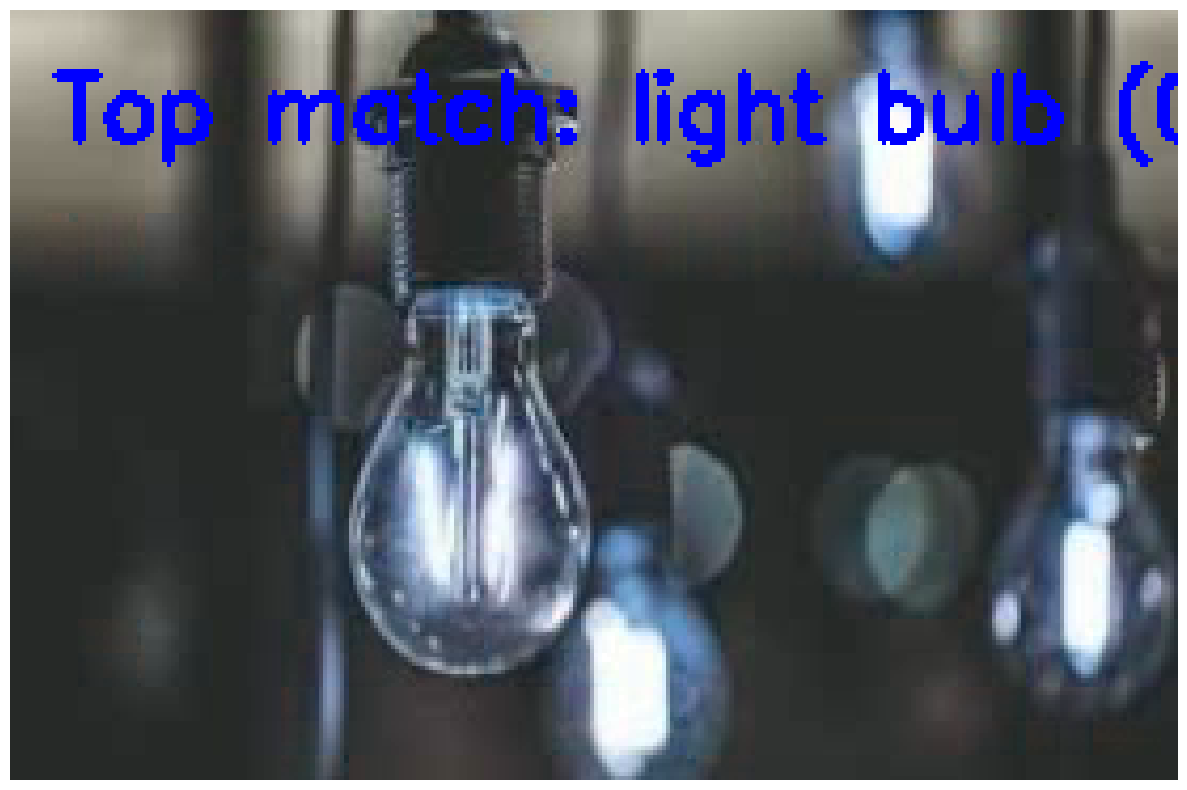

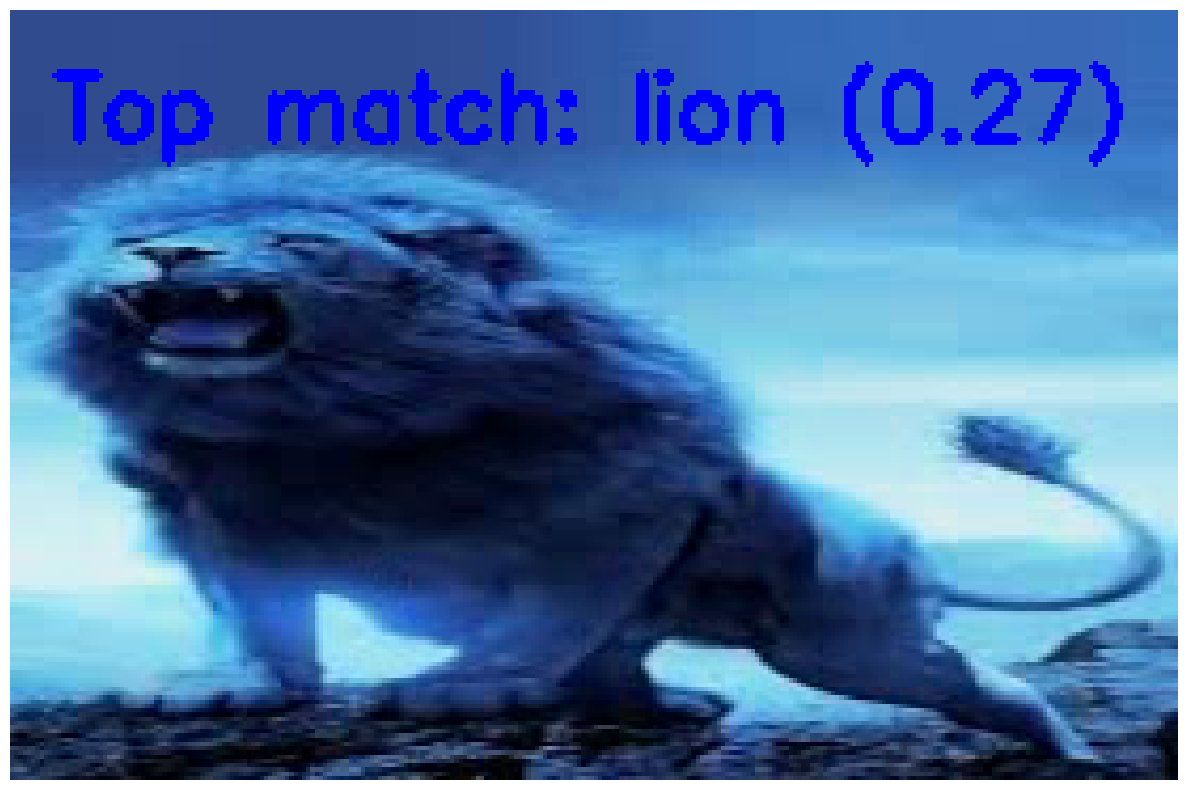

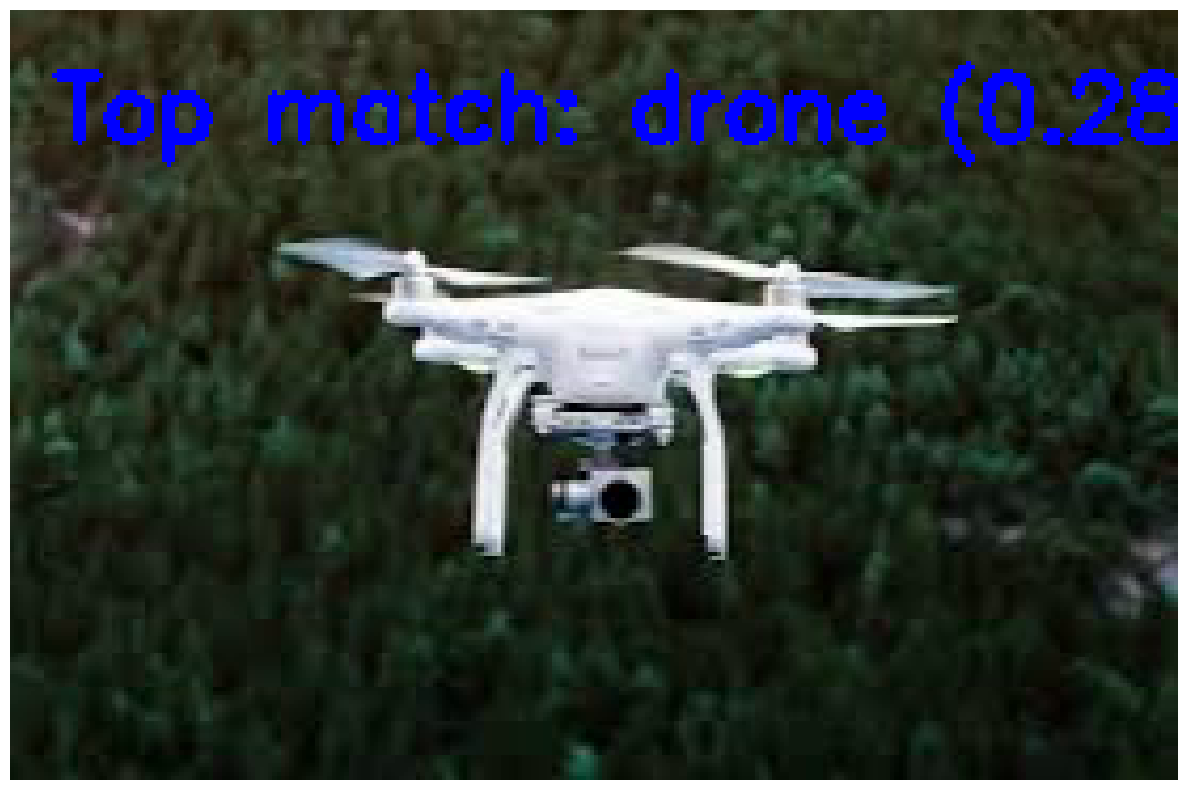

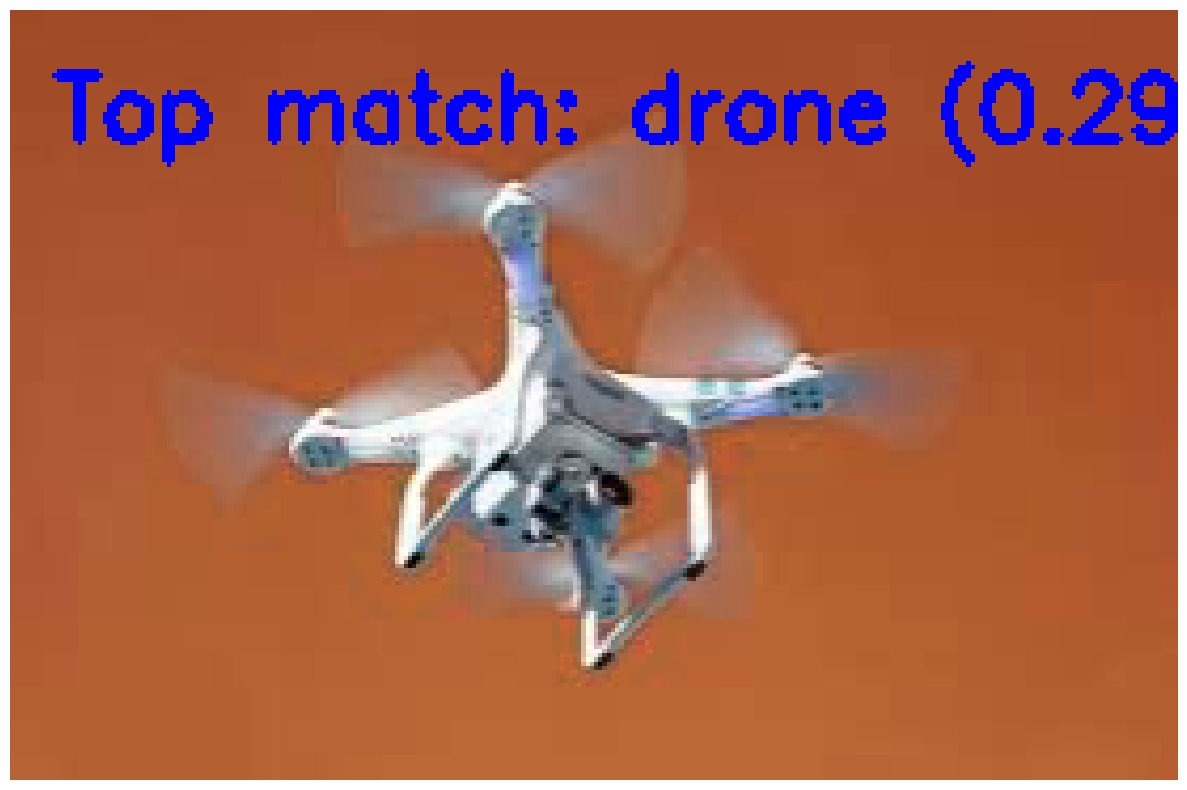

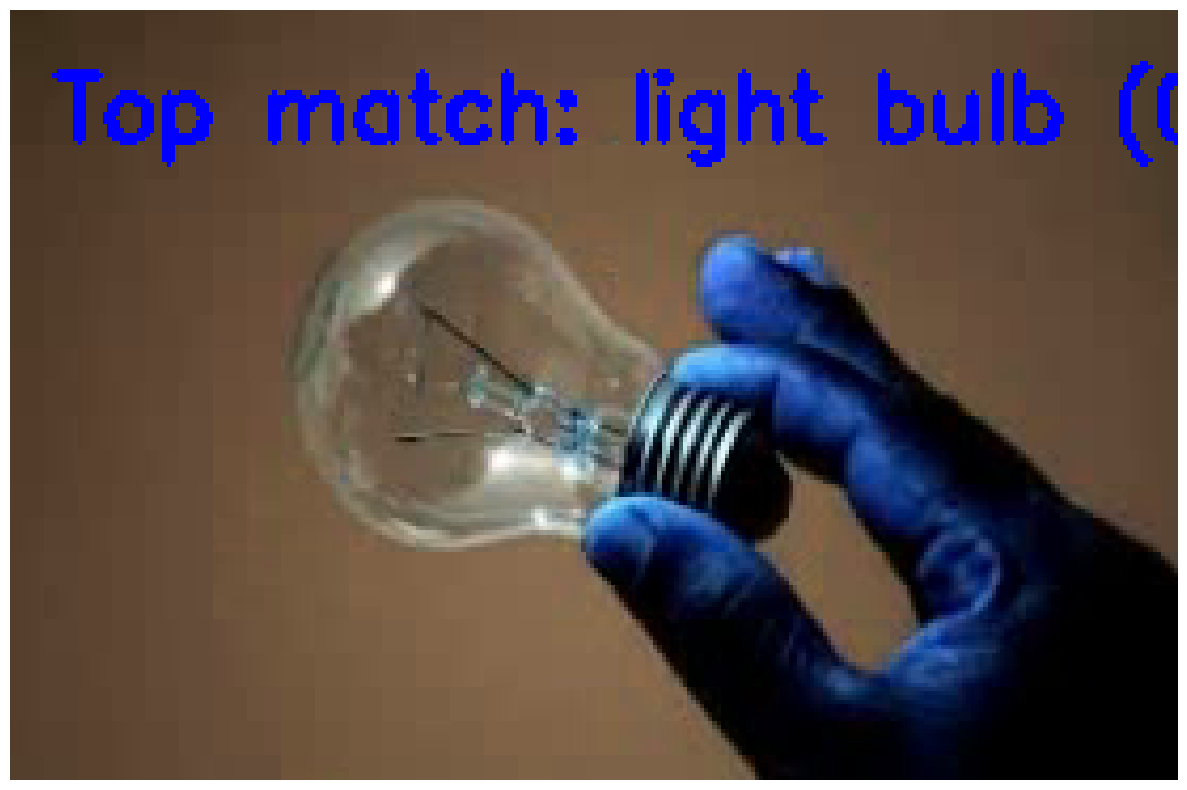

Video saved as 'output_with_clip.avi'
Average FPS: 8.55


In [ ]:
text_labels = ["matchbox and matchsticks", "pc monitor", "lion", "drone", "light bulb"]

process_video_with_clip(video_path, text_labels)